In [90]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Data preprocessing

In [2]:
data = pd.read_csv('combined_db.csv', skiprows=[0,2])

In [3]:
data.shape

(1972, 79)

In [4]:
data.head()

,Report timestamp,Experiment number,batch number,Expiration date,run # (cycle),bsf stage (nursery or fattening),Larvae density,replicate # (box),normal/abnormal replicate,box number (internal usage) \nnot mandatory,...,"Average temperature, C",Max temperature C,"Ammonia (max value), PPM",CO2 max value PPM,Sensors (yes/no),Monitoring,Pathogens,"Frass moisture, %",% of waste reduction (FW/FW),% of waste reduction (DM/DM)
0,24/02/1902 0:00,10.0,23061208,26/06/2023,1.0,nursery,25000,2.0,NaN,8.0,...,28.2,30.04,NaN,NaN,No,Continious,N.A,#VALUE!,#VALUE!,#VALUE!
1,03/12/1901 0:00,10.0,23061208,26/06/2023,1.0,nursery,25000,3.0,NaN,9.0,...,28.2,30.04,NaN,NaN,No,Continious,N.A,#VALUE!,#VALUE!,#VALUE!
2,08/05/2024 13:00,47.0,24040708,21/04/2024,1.0,nursery,"12,500",19.0,normal,19.0,...,28.2,33,NaN,NaN,No,Continious,N.A,#VALUE!,73.56,#VALUE!
3,08/05/2024 13:00,47.0,24040708,21/04/2024,1.0,nursery,"12,500",20.0,normal,20.0,...,28.2,33,NaN,NaN,No,Continious,N.A,#VALUE!,73.04,#VALUE!
4,08/05/2024 13:00,47.0,24040708,21/04/2024,1.0,nursery,"12,500",21.0,normal,21.0,...,28.2,33,NaN,NaN,No,Continious,N.A,#VALUE!,72.94,#VALUE!


In [5]:
data.describe()

,Experiment number,run # (cycle),replicate # (box),box number (internal usage) \nnot mandatory,chickenfeed age at the time of the experiment (in weeks),Diet number \n(from the file with the diets n_ for nursery and f_ for fattening),"Dry Matter, %","Total initial mass, kg","Protein, %","Carbs, without NDF \n%","Fat, \n%","Ash, %","100 Larvae biomass, gr","Average larval mass, mg","total larval biomass in the end of nursery (control), gr"
count,1573.000000,1553.000000,1966.000000,1061.000000,734.000000,1972.000000,1860.000000,1891.000000,1883.000000,1827.000000,1883.000000,1878.000000,1959.000000,1972.000000,998.000000
mean,14.301335,3.221507,2.499491,163.218662,4.309264,258.361055,31.803559,5.722815,17.954222,38.024240,6.802523,6.908441,12.473197,123.909407,816.591493
std,13.543568,30.965330,1.738283,196.540589,3.996724,150.280318,5.552458,2.315098,6.304038,13.616349,3.717725,4.957301,6.104974,61.680429,257.322430
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,11.000000,2.000000,2.400000,1.800000,0.500000,0.700000,1.200000,0.000000,360.000000
25%,5.000000,1.000000,1.000000,9.000000,1.000000,129.000000,28.560000,3.030000,14.810000,31.665000,4.000000,4.860000,5.900000,58.000000,600.000000
50%,9.000000,1.000000,2.000000,24.000000,2.000000,253.000000,30.400000,6.000000,19.000000,40.670000,6.660000,5.781310,13.670000,136.000000,832.900000
75%,18.000000,1.000000,3.000000,321.000000,7.000000,365.000000,36.000000,8.000000,21.400000,48.000000,10.000000,7.975000,17.290000,172.525000,867.030000
max,49.000000,500.000000,24.000000,629.000000,16.000000,500.000000,60.740000,9.000000,40.000000,68.000000,20.000000,48.221000,28.190000,281.900000,1266.000000


In [6]:
data[data['bsf stage (nursery or fattening)']=='fattening']['Diet number \n(from the file with the diets n_ for nursery and f_ for fattening)'].nunique()

251

In [7]:
without_na = data.dropna(subset=[' total larval  biomass, gr','Average larval  mass, mg','Fat, %', 'Recalculated protein, %'])
without_na[without_na['bsf stage (nursery or fattening)']=='fattening']['Diet number \n(from the file with the diets n_ for nursery and f_ for fattening)'].nunique()

171

In [8]:
data[data['bsf stage (nursery or fattening)']=='nursery']['Diet number \n(from the file with the diets n_ for nursery and f_ for fattening)'].nunique()

134

In [9]:
data = data.dropna(subset=['Larvae density'])

In [10]:
data.loc[data['Larvae density'] == '12.5K', 'Larvae density'] = 12500

In [11]:
data.loc[data['Larvae density'] == '12,500', 'Larvae density'] = 12500

In [12]:
data.loc[data['Larvae density'] == '25,000', 'Larvae density'] = 25000

In [13]:
data['Larvae density'] = data['Larvae density'].astype('int')

In [14]:
data = data[data[' total larval  biomass, gr']!="N.A"]
data = data[data[' total larval  biomass, gr']!='#DIV/0!']
data = data[data[' total larval  biomass, gr']!='#VALUE!']

In [15]:
data = data[data['Average larval  mass, mg']!='#VALUE!']

In [16]:
data.head()

,Report timestamp,Experiment number,batch number,Expiration date,run # (cycle),bsf stage (nursery or fattening),Larvae density,replicate # (box),normal/abnormal replicate,box number (internal usage) \nnot mandatory,...,"Average temperature, C",Max temperature C,"Ammonia (max value), PPM",CO2 max value PPM,Sensors (yes/no),Monitoring,Pathogens,"Frass moisture, %",% of waste reduction (FW/FW),% of waste reduction (DM/DM)
0,24/02/1902 0:00,10.0,23061208,26/06/2023,1.0,nursery,25000,2.0,NaN,8.0,...,28.2,30.04,NaN,NaN,No,Continious,N.A,#VALUE!,#VALUE!,#VALUE!
1,03/12/1901 0:00,10.0,23061208,26/06/2023,1.0,nursery,25000,3.0,NaN,9.0,...,28.2,30.04,NaN,NaN,No,Continious,N.A,#VALUE!,#VALUE!,#VALUE!
2,08/05/2024 13:00,47.0,24040708,21/04/2024,1.0,nursery,12500,19.0,normal,19.0,...,28.2,33,NaN,NaN,No,Continious,N.A,#VALUE!,73.56,#VALUE!
3,08/05/2024 13:00,47.0,24040708,21/04/2024,1.0,nursery,12500,20.0,normal,20.0,...,28.2,33,NaN,NaN,No,Continious,N.A,#VALUE!,73.04,#VALUE!
4,08/05/2024 13:00,47.0,24040708,21/04/2024,1.0,nursery,12500,21.0,normal,21.0,...,28.2,33,NaN,NaN,No,Continious,N.A,#VALUE!,72.94,#VALUE!


In [17]:
columns = ['Dry Matter, %','Diet number \n(from the file with the diets n_ for nursery and f_ for fattening)','bsf stage (nursery or fattening)','Cycle, days','Initial Moisture', 'Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%','NDF, %', 'Ash, %','company_name',' total larval  biomass, gr','Average larval  mass, mg','Fat, %','Recalculated protein, %',
      "experiment purpose",'Survival%','Larvae density','start date (larvae t = 0 )','batch number '] #,'% of waste reduction (FW/FW)', '% of waste reduction (DM/DM)']
    #  'Feed conversion efficiency (DM/FW) without nursery',   
    #'Feed conversion efficiency (DM/FW) with nursery',
       #'Feed conversion efficiency (FW/FW) without nursery',
       #'Feed conversion efficiency (FW/FW) with nursery']

In [18]:
data = data[data["experiment purpose"]!='larvae production']

In [19]:
value_to_find ='לא סנין'
  #'לא סנין' # 'N.A' #'#VALUE!'#  'לא למלא, מחושב' 

for column in data.columns:
    if value_to_find in data[column].values:
        print(f"Value '{value_to_find}' found in column '{column}'")

Value 'לא סנין' found in column ' total larval  biomass, gr'
Value 'לא סנין' found in column 'Frass, kg'


/tmp/ipykernel_152208/1989860295.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if value_to_find in data[column].values:


In [20]:
rows_to_remove = data[data.isin([value_to_find]).any(axis=1)]

data = data.drop(rows_to_remove.index)

In [21]:
value_to_find ='לא למלא, מחושב'
  #'לא סנין' # 'N.A' #'#VALUE!'#  'לא למלא, מחושב' 

for column in data.columns:
    if value_to_find in data[column].values:
        print(f"Value '{value_to_find}' found in column '{column}'")

Value 'לא למלא, מחושב' found in column 'Feed conversion efficiency (DM/FW) without nursery'
Value 'לא למלא, מחושב' found in column 'Feed conversion efficiency (DM/FW) with nursery'
Value 'לא למלא, מחושב' found in column 'Feed conversion efficiency (FW/FW) without nursery'
Value 'לא למלא, מחושב' found in column 'Feed conversion efficiency (FW/FW) with nursery'


/tmp/ipykernel_152208/2061384117.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if value_to_find in data[column].values:


In [22]:
rows_to_remove = data[data.isin([value_to_find]).any(axis=1)]

data = data.drop(rows_to_remove.index)

In [23]:
value_to_find = 'שק מתאריך 04/04' 
for column in data.columns:
    if value_to_find in data[column].values:
        print(f"Value '{value_to_find}' found in column '{column}'")

Value 'שק מתאריך 04/04' found in column 'NDF, %'


/tmp/ipykernel_152208/17564045.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if value_to_find in data[column].values:


In [24]:
rows_to_remove = data[data.isin([value_to_find]).any(axis=1)]

data = data.drop(rows_to_remove.index)

In [25]:
data[[ 'Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%','NDF, %', 'Ash, %',' total larval  biomass, gr','Average larval  mass, mg']] = data[['Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%','NDF, %', 'Ash, %',' total larval  biomass, gr','Average larval  mass, mg']].replace(u'\xa0', u'0').astype("float")

In [26]:
data['Larvae density'].unique()

array([25000, 12500,  6250])

In [27]:
data = data.rename(columns={'Diet number \n(from the file with the diets n_ for nursery and f_ for fattening)': 'Diet_num'})

### Dates processing

In [28]:
data['date'] = pd.to_datetime(data['start date (larvae t = 0 )'] , dayfirst=True)

data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.weekday  # Monday=0, Sunday=6

### Fattening

In [29]:
data_fattening =data[data['bsf stage (nursery or fattening)']=="fattening"]

In [30]:
#drop all rows with nan values for target variables
data_fattening = data_fattening.dropna(subset = [' total larval  biomass, gr','Average larval  mass, mg','Fat, %', 'Recalculated protein, %'])

### Nursery

In [31]:
data_nursery =data[data['bsf stage (nursery or fattening)']=="nursery"]

In [32]:
#drop all rows with nan values for target variables
data_nursery = data_nursery.dropna(subset = [' total larval  biomass, gr','Average larval  mass, mg'])

### Isolate diet 500

In [33]:
data_fattening_without_500 = data_fattening[data_fattening["Diet_num"]!='500']

In [34]:
data_fattening_without_500 = data_fattening[data_fattening["Diet_num"]!= 500]

In [35]:
data_fattening_without_500 = data_fattening_without_500[data_fattening["Diet_num"]!='f_500']

/tmp/ipykernel_152208/85537287.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_fattening_without_500 = data_fattening_without_500[data_fattening["Diet_num"]!='f_500']


In [36]:
value_to_find = '#VALUE!' 
  #'לא סנין' # 'N.A' #'#VALUE!'#

for column in data_fattening_without_500.columns:
    if value_to_find in data_fattening_without_500[column].values:
        print(f"Value '{value_to_find}' found in column '{column}'")

Value '#VALUE!' found in column 'Number of larvae'
Value '#VALUE!' found in column 'Survival%'
Value '#VALUE!' found in column 'Feed conversion efficiency (DM/FW) without nursery'
Value '#VALUE!' found in column 'Feed conversion efficiency (DM/FW) with nursery'
Value '#VALUE!' found in column 'Feed conversion efficiency (DM/DM) with nursery'
Value '#VALUE!' found in column 'Feed conversion efficiency (FW/FW) without nursery'
Value '#VALUE!' found in column 'Feed conversion efficiency (FW/FW) with nursery'
Value '#VALUE!' found in column 'Recalculated protein, %'
Value '#VALUE!' found in column 'Total Protein'
Value '#VALUE!' found in column 'Frass moisture, %'
Value '#VALUE!' found in column '% of waste reduction (FW/FW)'
Value '#VALUE!' found in column '% of waste reduction (DM/DM)'


/tmp/ipykernel_152208/2637989871.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if value_to_find in data_fattening_without_500[column].values:


In [37]:
rows_to_remove = data_fattening_without_500[data_fattening_without_500.isin([value_to_find]).any(axis=1)]

# Remove rows containing the value
data_fattening_without_500 = data_fattening_without_500.drop(rows_to_remove.index)

In [38]:
data_fattening_without_500[[' total larval  biomass, gr','Average larval  mass, mg','Fat, %','Recalculated protein, %']]=data_fattening_without_500[[' total larval  biomass, gr','Average larval  mass, mg','Fat, %','Recalculated protein, %']].replace(u'\xa0', u'0').astype('float')

In [39]:
data_fattening_500 = data_fattening[(data_fattening["Diet_num"] == '500') | (data_fattening["Diet_num"] == 'f_500')]

In [40]:
data_nursery_500 = data_nursery[(data_nursery["Diet_num"] == '500') | (data_nursery["Diet_num"] == 'n_500')]

In [41]:
data_nursery_without_500 = data_nursery[data_nursery["Diet_num"]!='n_500']

In [42]:
data_nursery_without_500 = data_nursery[data_nursery["Diet_num"]!='500']

In [43]:
data_nursery_without_500 = data_nursery[data_nursery["Diet_num"]!=500]

In [44]:
data_nursery_without_500.columns

Index(['Report timestamp', 'Experiment number', 'batch number ',
       'Expiration date', 'run # (cycle)', 'bsf stage (nursery or fattening)',
       'Larvae density', 'replicate # (box)', 'normal/abnormal replicate',
       'box number (internal usage) \nnot mandatory', 'experiment purpose',
       'start date (larvae t = 0 )', 'chickenfeed storage',
       'chickenfeed age at the time of the experiment (in weeks)', 'Diet_num',
       'Dry Matter, %', 'Total initial mass, kg', 'starting pH',
       'Energy yield [MJ/kg]\nnot mandatory', 'The day of max temperature',
       'Max temperature', 'Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%',
       'NDF, %', 'Ash, %', 'NaCl, %', 'PH', 'Ca', 'P', 'Zn',
       'Harvesting timestamp ', 'Cycle, days', '100 Larvae biomass, gr',
       'Average larval  mass, mg', 'Number of larvae', 'Survival%',
       ' total larval  biomass, gr',
       'total larval biomass in the end of nursery (control), gr',
       'Feed conversion efficiency (DM/FW

In [45]:
data_nursery_without_500[[ ' total larval  biomass, gr',
       'Average larval  mass, mg']] = data_nursery_without_500[[ ' total larval  biomass, gr',
       'Average larval  mass, mg']].astype('float')

/tmp/ipykernel_152208/1571511402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nursery_without_500[[ ' total larval  biomass, gr',


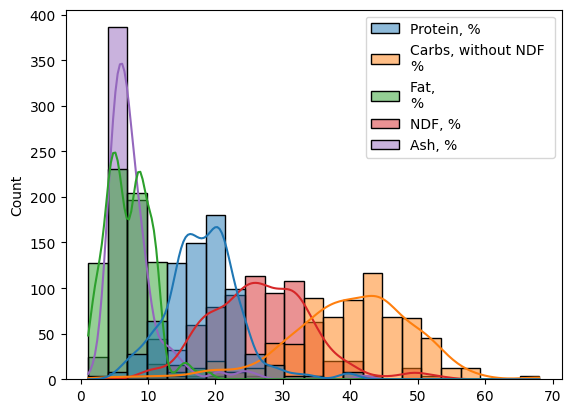

In [46]:
sns.histplot(data_fattening_without_500[['Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%','NDF, %', 'Ash, %']], kde=True)
plt.show()

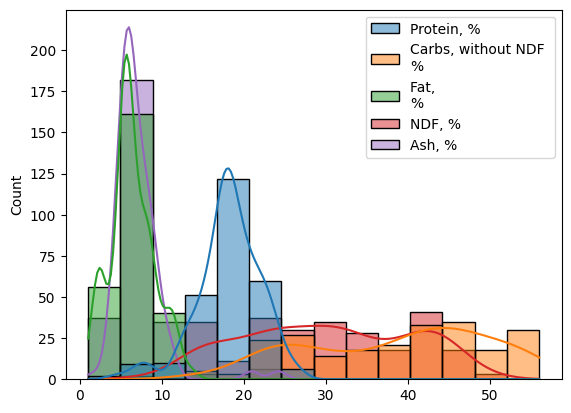

In [47]:
sns.histplot(data_nursery_without_500[['Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%','NDF, %', 'Ash, %']], kde=True)
plt.show()

### Fattening statistics

In [48]:
data_fattening_without_500['Fat, %'] = data_fattening_without_500['Fat, %'].astype('float')

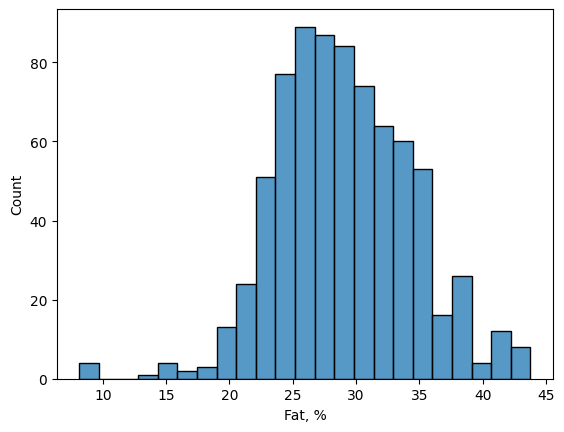

In [49]:
sns.histplot(data_fattening_without_500['Fat, %'])
plt.show()

In [50]:
data_fattening_without_500['Recalculated protein, %'] = data_fattening_without_500['Recalculated protein, %'].astype('float')

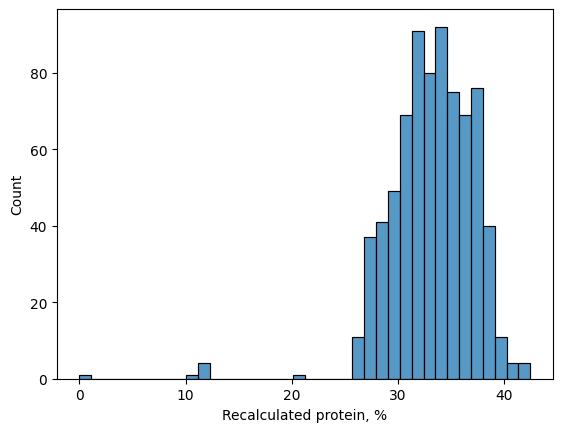

In [51]:
sns.histplot(data_fattening_without_500['Recalculated protein, %'])
plt.show()

In [52]:
data_fattening_without_500 = data_fattening_without_500[data_fattening_without_500['Recalculated protein, %']>0]

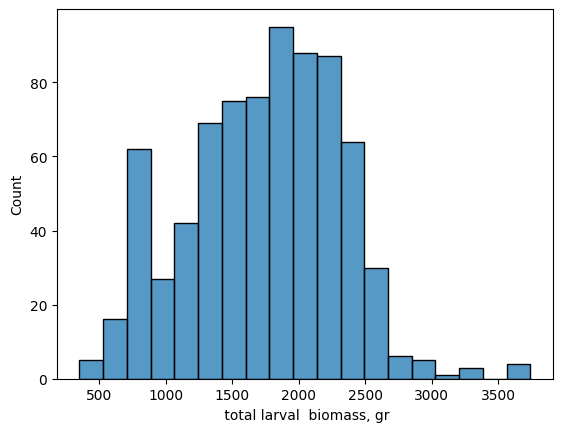

In [53]:
sns.histplot(data_fattening_without_500[' total larval  biomass, gr'])
plt.show()

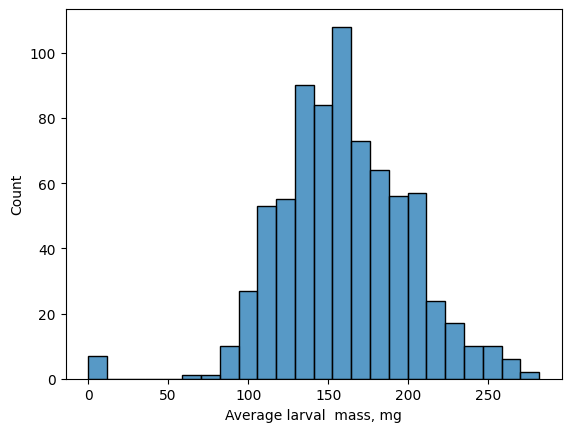

In [54]:
sns.histplot(data_fattening_without_500['Average larval  mass, mg'])
plt.show()

In [55]:
data_fattening_without_500 = data_fattening_without_500[data_fattening_without_500['Average larval  mass, mg']>0]

In [56]:
data_fattening_without_500 = data_fattening_without_500[data_fattening_without_500[' total larval  biomass, gr']>0]

### Nursery without 500 statistics

In [57]:
data_nursery_without_500['Average larval  mass, mg'] = data_nursery_without_500['Average larval  mass, mg'].astype('float')

/tmp/ipykernel_152208/2116322736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nursery_without_500['Average larval  mass, mg'] = data_nursery_without_500['Average larval  mass, mg'].astype('float')


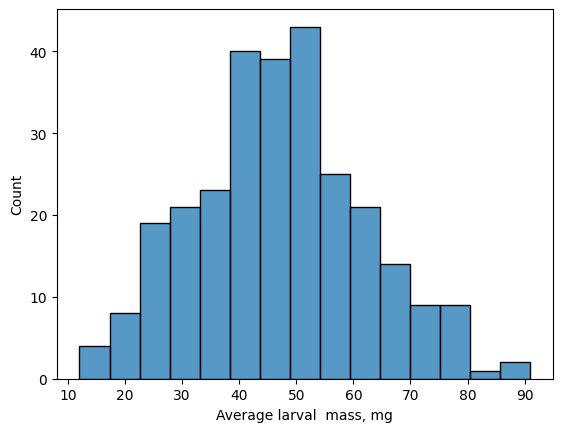

In [58]:
sns.histplot(data_nursery_without_500['Average larval  mass, mg'])
plt.show()

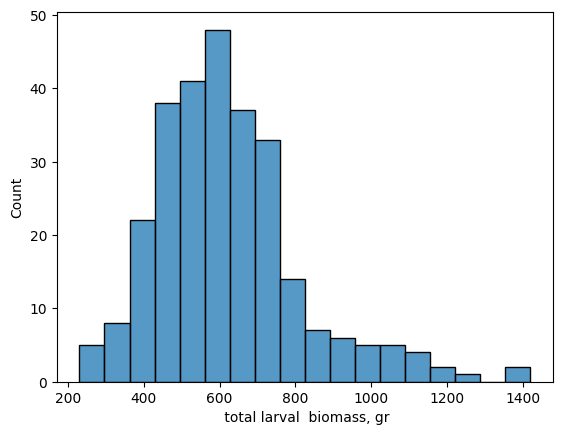

In [59]:
sns.histplot(data_nursery_without_500[' total larval  biomass, gr'])
plt.show()

In [60]:
data_nursery_without_500['Cycle, days'] = data_nursery_without_500['Cycle, days'].astype('float')

/tmp/ipykernel_152208/2155079954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nursery_without_500['Cycle, days'] = data_nursery_without_500['Cycle, days'].astype('float')


In [61]:
data_nursery_without_500['Cycle, days'].describe()

count    278.000000
mean       7.934385
std        1.908600
min        5.720000
25%        6.944583
50%        7.350000
75%        8.000000
max       19.000000
Name: Cycle, days, dtype: float64

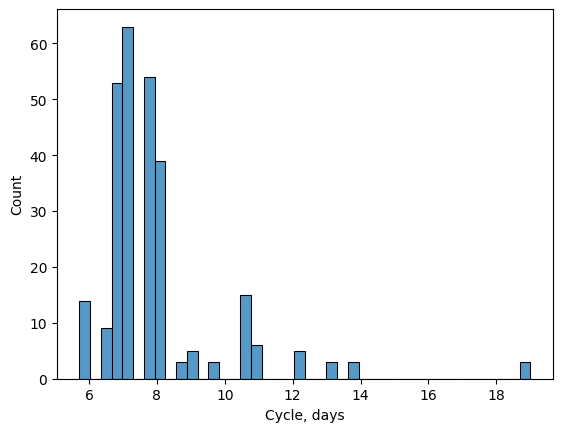

In [62]:
sns.histplot(data_nursery_without_500['Cycle, days'])
plt.show()

In [63]:
data_fattening_without_500[['Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%','NDF, %', 'Ash, %']] = data_fattening_without_500[['Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%','NDF, %', 'Ash, %']].astype('float')

In [64]:
data_fattening_without_500[[' total larval  biomass, gr','Average larval  mass, mg','Fat, %', 'Recalculated protein, %']] = data_fattening_without_500[[' total larval  biomass, gr','Average larval  mass, mg','Fat, %', 'Recalculated protein, %']].replace(u'\xa0', u'0').astype('float')

In [65]:
data_fattening_without_500['Cycle, days'] = data_fattening_without_500['Cycle, days'].astype('float')

<AxesSubplot: xlabel='day_of_week', ylabel=' total larval  biomass, gr'>

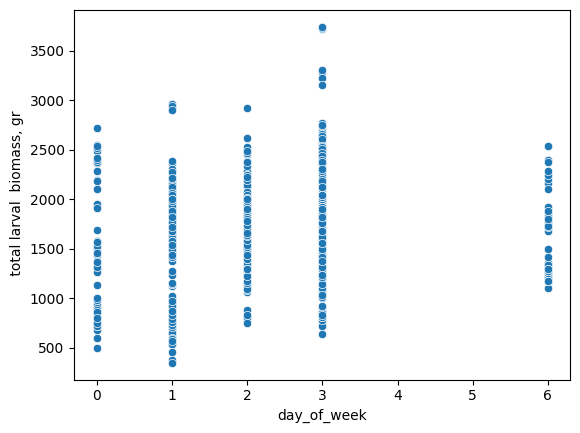

In [66]:
sns.scatterplot(data=data_fattening_without_500, x='day_of_week', y=' total larval  biomass, gr')

<AxesSubplot: xlabel='Fat, \n%', ylabel='Fat, %'>

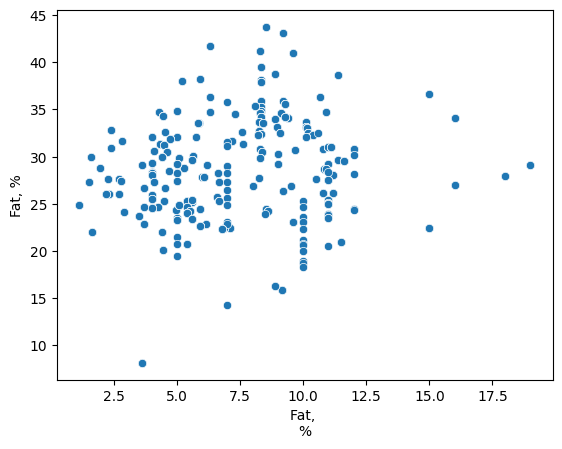

In [67]:
sns.scatterplot(data=data_fattening_without_500, x='Fat, \n%', y='Fat, %')

In [68]:
data_fattening_without_500_run = data_fattening_without_500.copy()

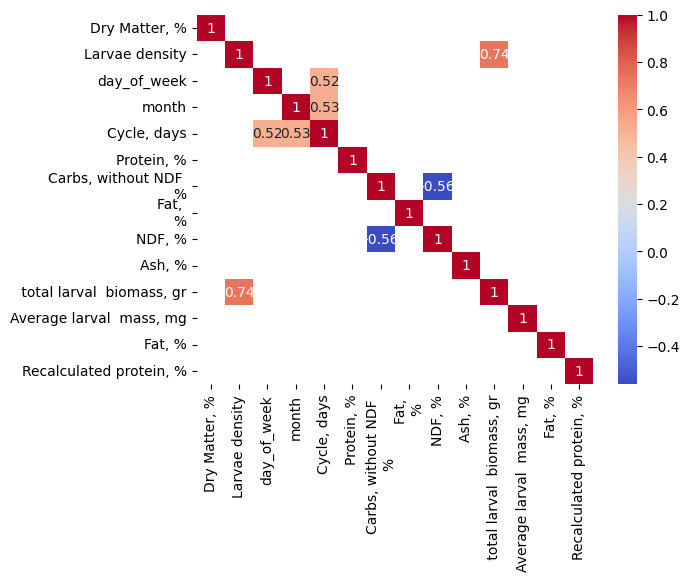

In [69]:

# Calculate the correlation matrix
corr_matrix = data_fattening_without_500[['Dry Matter, %','Larvae density','day_of_week','month','Cycle, days','Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%','NDF, %', 'Ash, %',' total larval  biomass, gr','Average larval  mass, mg','Fat, %','Recalculated protein, %']].corr()

mask = np.abs(corr_matrix) <= 0.5
# Create a heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',mask=mask)
plt.show()

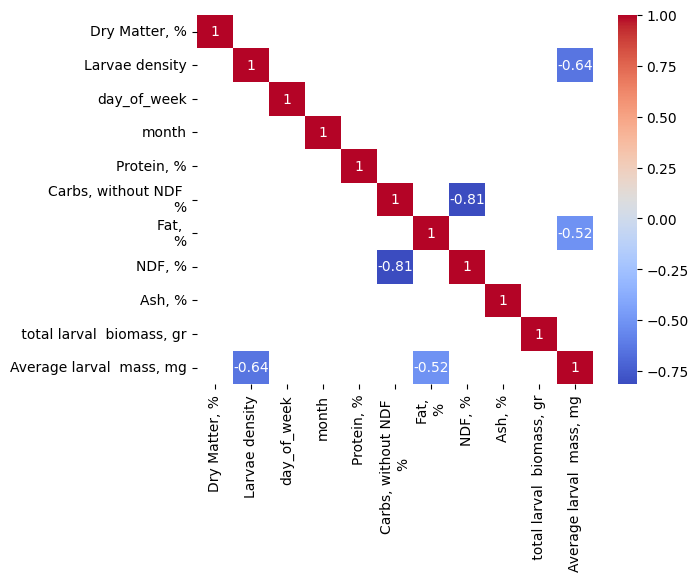

In [70]:
# Calculate the correlation matrix
corr_matrix = data_nursery_without_500[['Dry Matter, %','Larvae density','day_of_week','month','Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%','NDF, %', 'Ash, %',' total larval  biomass, gr','Average larval  mass, mg']].corr()
mask = np.abs(corr_matrix) <= 0.5
# Create a heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',mask=mask)
plt.show()

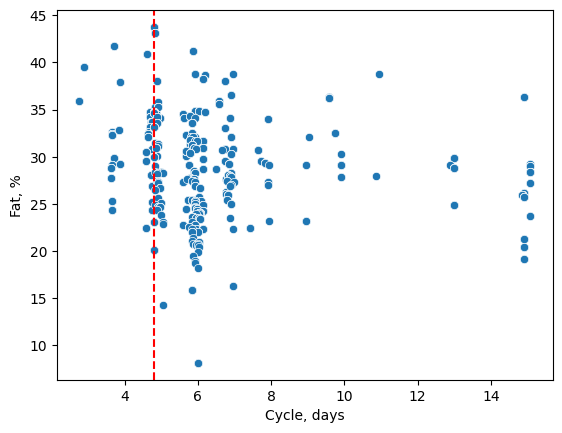

In [71]:
sns.scatterplot(data=data_fattening_without_500, x='Cycle, days', y='Fat, %')

# Find the x value for which y is maximum
x_max = data_fattening_without_500['Cycle, days'][data_fattening_without_500['Fat, %'].idxmax()]

# Add a vertical line at x_max
plt.axvline(x=x_max, color='r', linestyle='--')

# Show the plot
plt.show()

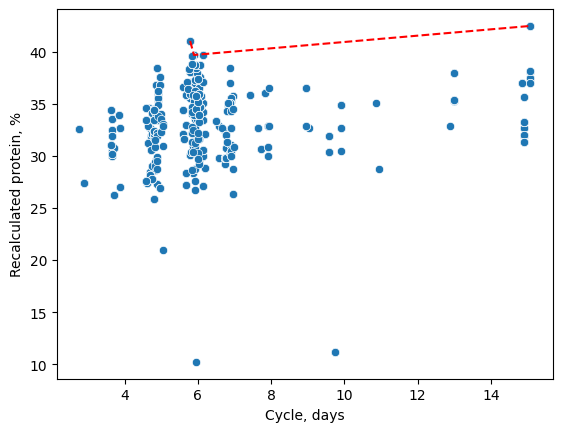

In [72]:
sns.scatterplot(data=data_fattening_without_500, x='Cycle, days', y='Recalculated protein, %')

# Find the top 5 maximum y values and store them in a new DataFrame
top_5_max_points_df = data_fattening_without_500.nlargest(10, 'Recalculated protein, %')

# Sort the DataFrame by 'Cycle, days' to ensure the line is plotted correctly
top_5_max_points_df = top_5_max_points_df.sort_values('Cycle, days')

# Plot a line connecting the top 5 maximum points
plt.plot(top_5_max_points_df['Cycle, days'], top_5_max_points_df['Recalculated protein, %'], color='r', linestyle='--')

plt.show()

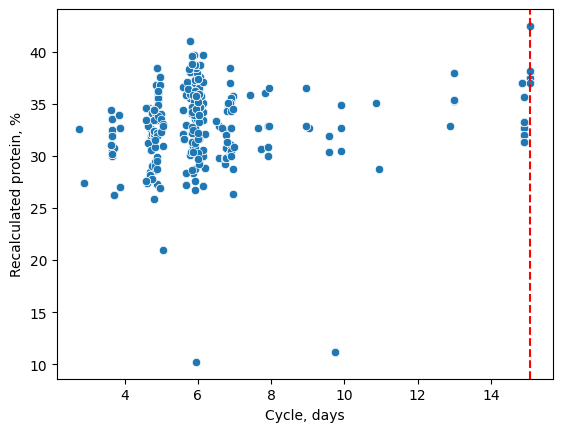

In [73]:
sns.scatterplot(data=data_fattening_without_500, x='Cycle, days', y='Recalculated protein, %')

# Find the x value for which y is maximum
x_max = data_fattening_without_500['Cycle, days'][data_fattening_without_500['Recalculated protein, %'].idxmax()]

# Add a vertical line at x_max
plt.axvline(x=x_max, color='r', linestyle='--')

# Show the plot
plt.show()

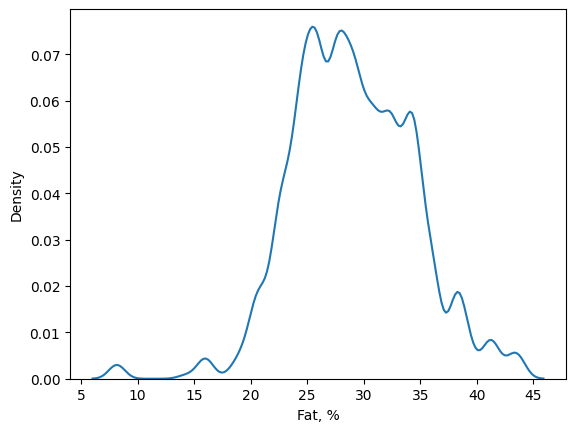

In [74]:
sns.kdeplot(data=data_fattening_without_500['Fat, %'], bw_adjust=0.5)
plt.show()

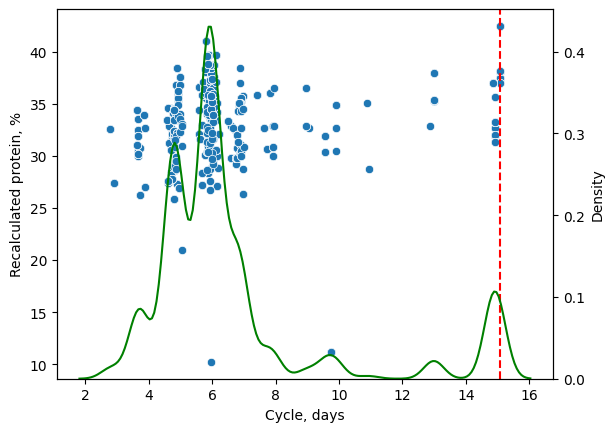

In [75]:
fig, ax1 = plt.subplots()

# Scatterplot
sns.scatterplot(data=data_fattening_without_500, x='Cycle, days', y='Recalculated protein, %', ax=ax1)

# Find the x value for which y is maximum
x_max = data_fattening_without_500['Cycle, days'][data_fattening_without_500['Recalculated protein, %'].idxmax()]

# Add a vertical line at x_max
ax1.axvline(x=x_max, color='r', linestyle='--')

# Create a second y-axis for the KDE plot
ax2 = ax1.twinx()

# KDE plot with adjusted bandwidth
sns.kdeplot(data=data_fattening_without_500['Cycle, days'], bw_adjust=0.4, color='g', ax=ax2)

# Show the plot
plt.show()

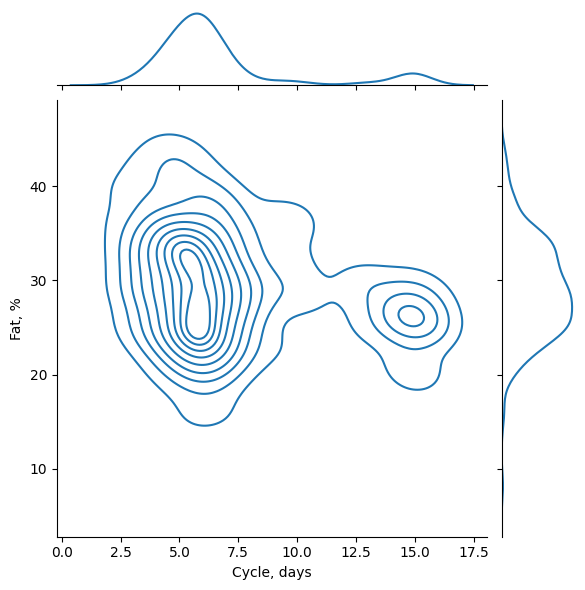

In [76]:
sns.jointplot(data=data_fattening_without_500, x='Cycle, days', y='Fat, %', kind='kde')

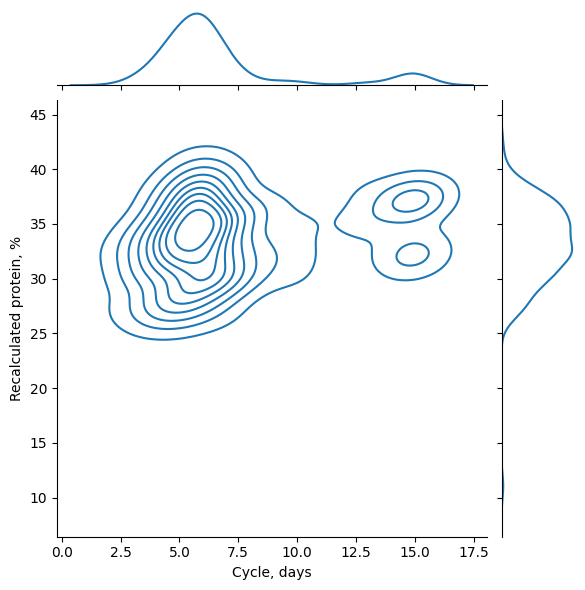

In [77]:
sns.jointplot(data=data_fattening_without_500, x='Cycle, days', y='Recalculated protein, %', kind='kde')

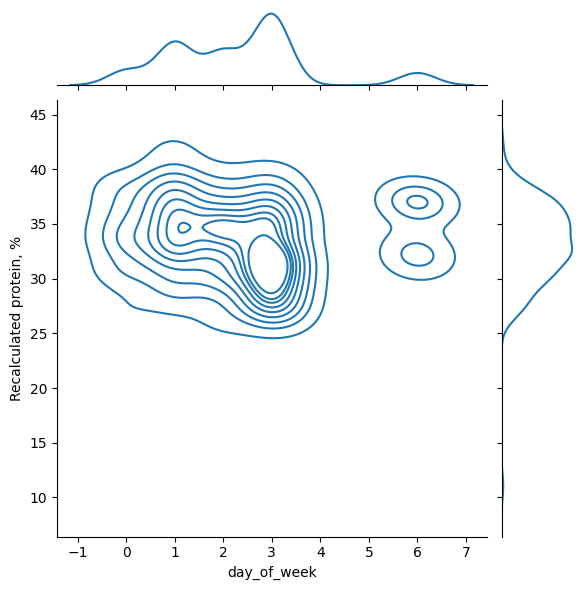

In [78]:
sns.jointplot(data=data_fattening_without_500, x='day_of_week', y='Recalculated protein, %', kind='kde')

In [79]:
data_fattening_without_500_run = data_fattening_without_500[['Diet_num','Larvae density',' total larval  biomass, gr','Average larval  mass, mg','Fat, %', 'Recalculated protein, %', 'Cycle, days','NDF, %', 'Ash, %', 'Protein, %', 'Carbs, without NDF \n%', 'Fat, \n%','Dry Matter, %','month','day_of_week']].dropna()

In [80]:
grouped_df = data_fattening_without_500_run.groupby('Diet_num')['Fat, %'].describe()

grouped_df[grouped_df['std'] > 2]

,count,mean,std,min,25%,50%,75%,max
Diet_num,,,,,,,,
122,8.0,28.015000,2.164816,25.990000,25.990000,28.015000,30.040000,30.040000
128,16.0,31.235000,3.182490,25.990000,30.580000,32.625000,33.280000,33.700000
191,8.0,37.885000,3.511813,34.600000,34.600000,37.885000,41.170000,41.170000
196,8.0,30.190000,4.147894,26.310000,26.310000,30.190000,34.070000,34.070000
249,19.0,28.440000,2.387169,25.450000,25.940000,28.050000,29.320000,32.090000
278,4.0,21.914628,3.539100,18.755981,18.906840,21.828820,24.836608,25.244892
280,8.0,26.920433,4.465712,20.469083,23.510972,27.466217,30.980000,30.980000
281,4.0,29.974414,4.538224,25.636624,26.861651,29.217653,32.330416,35.825729
282,4.0,27.981840,2.893824,24.917035,26.092575,27.753159,29.642425,31.504005


In [81]:
data_nursery_without_500.groupby('Diet_num')['Average larval  mass, mg'].describe()

,count,mean,std,min,25%,50%,75%,max
Diet_num,,,,,,,,
3,3.0,38.333333,2.516611,36.00,37.0000,38.000,39.5000,41.00
4,3.0,28.000000,1.732051,26.00,27.5000,29.000,29.0000,29.00
5,3.0,41.666667,4.932883,36.00,40.0000,44.000,44.5000,45.00
25,3.0,38.333333,3.214550,36.00,36.5000,37.000,39.5000,42.00
26,3.0,58.000000,2.000000,56.00,57.0000,58.000,59.0000,60.00
...,...,...,...,...,...,...,...,...
378,2.0,57.500000,4.949747,54.00,55.7500,57.500,59.2500,61.00
379,2.0,60.515000,10.585389,53.03,56.7725,60.515,64.2575,68.00
380,3.0,25.273333,2.202756,23.22,24.1100,25.000,26.3000,27.60


### Running model on fattening data

In [102]:
company_data = data_fattening_without_500_run

In [103]:
#10 cross validation (k=10)
group_kfold = GroupKFold(n_splits=10)

X = company_data[['Diet_num','Ash, %', 'NDF, %','Carbs, without NDF \n%','Cycle, days','Protein, %','Fat, \n%','month','Larvae density','day_of_week']] #,'batch number ','Larvae density']]

y = company_data[[' total larval  biomass, gr','Average larval  mass, mg','Fat, %', 'Recalculated protein, %']]


In [104]:
groups = company_data["Diet_num"]

In [105]:
def run_fattening_model(xg_reg, groups, X,y):
    rmse_scores = []
    mae_scores = []
    me_scores = []

    one_hot_features = ['month','Larvae density','day_of_week']
    scale_features = [col for col in X.columns if col not in one_hot_features and col != 'Diet_num']

    preprocessor_X = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), scale_features),
            ('cat', 'passthrough', one_hot_features)
        ])

    pipeline_X = Pipeline(steps=[('preprocessor', preprocessor_X)])

    scaler_y = MinMaxScaler()

    for train_idx, test_idx in group_kfold.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        print("Train diet numbers:", X_train['Diet_num'].unique())
        print("Test diet numbers:", X_test['Diet_num'].unique())

        X_train = X_train.drop('Diet_num', axis=1)
        X_test = X_test.drop('Diet_num', axis=1)


        X_train_transformed = pipeline_X.fit_transform(X_train)
        X_test_transformed = pipeline_X.transform(X_test)

        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        model = MultiOutputRegressor(xg_reg)
        model.fit(X_train_transformed, y_train_scaled)

        y_pred_scaled = model.predict(X_test_transformed)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)

        rmse_local_score = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
        mae_local_score = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
        mse_local_score = mean_squared_error(y_test, y_pred, multioutput='raw_values')
        me_score =  np.mean(y_test - y_pred)

        for i, target in enumerate(y_test.columns):
            print(f"{target} RMSE: {rmse_local_score[i]:.2f}")

        rmse_scores.append(rmse_local_score)
        mae_scores.append(mae_local_score)
        me_scores.append(me_score)

        print("-------------------------------")    


    avg_rmse_scores = np.mean(rmse_scores, axis=0)
    avg_mae_scores = np.mean(mae_scores, axis=0)
    avg_me_scores= np.mean(me_scores, axis=0)
    std_me_scores = np.std(me_scores, axis=0)


    for i, target in enumerate(y_test.columns):
        print(f"Average {target} RMSE: {avg_rmse_scores[i]:.2f}")
        print(f"Average {target} MAE: {avg_mae_scores[i]:.2f}")
        print(f"Average {target} ME: {avg_me_scores[i]:.2f}")

### Linear Regression for fattening

In [106]:
xg_reg = LinearRegression() 

In [107]:
run_fattening_model(xg_reg, groups, X,y)

Train diet numbers: [294 187 191 202 197 190 201 200 205 196 128 195 198 296 210 208 192 139
 193 212 130 293 122 204 206 295 189 211 220 123 194 207 188 299 135 125
 297 292 133 203 124 126 136 132 234 221 240 281 109 230 232  68  41  73
 288 245  36  38  42  56  43 284  28 249  37 235  29 282  75  39 280 228
  67 251 107  71 241 285  69 121 222 248 254  19 119 236  16 283  74 286
 252 244 255  24  11 237  17  70 408 239 242  49  18 134 127  13   9 247
  52   2 278 238 229 120  78   6  15  12 225   8  35 223  40 287 243  10
 253 101  90 256 226  33 108 224 279   7  77  14]
Test diet numbers: [199 209 298   1 233 289 250  44  30 257]
 total larval  biomass, gr RMSE: 489.06
Average larval  mass, mg RMSE: 38.75
Fat, % RMSE: 5.49
Recalculated protein, % RMSE: 6.17
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 190   1 200 205 196 128 195 198 296 210
 208 192 139 193 212 130 293 122 204 206 295 189 211 220 123 194 207 299
 135 125 297 292 133 203 124 1

/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/dready/

 total larval  biomass, gr RMSE: 253.13
Average larval  mass, mg RMSE: 26.99
Fat, % RMSE: 3.66
Recalculated protein, % RMSE: 2.12
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 190 201   1 205 196 128 195 198 296 210
 208 192 139 193 212 293 122 204 206 295 189 211 220 123 194 207 188 299
 135 125 297 292 133 126 136 132 240 281 109 230 232  68  41  73 245  36
  38  42  56  43 233  28 249  37 235  29 282  75  39 280 228  67 107  71
 241 285  69 121 222 248 289 254 250  19 119 236 283  74 286 252  44 244
 255  24  11  30 237  17  70 408 239 242  18 134 127  13   9 247  52   2
 278 238 229  78   6  15  12 225   8  35 257 223  40 287 243  10 253  90
 226 108 224 279  77  14]
Test diet numbers: [200 130 203 124 234 221 288 284 251  16  49 120 101 256  33   7]
 total larval  biomass, gr RMSE: 330.88
Average larval  mass, mg RMSE: 34.95
Fat, % RMSE: 5.21
Recalculated protein, % RMSE: 2.46
-------------------------------
Train diet numbers: [294 187 199 1

/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### Random Forest

In [108]:
xg_reg = RandomForestRegressor(n_estimators=100, random_state=42) 

In [109]:
run_fattening_model(xg_reg, groups, X,y)

Train diet numbers: [294 187 191 202 197 190 201 200 205 196 128 195 198 296 210 208 192 139
 193 212 130 293 122 204 206 295 189 211 220 123 194 207 188 299 135 125
 297 292 133 203 124 126 136 132 234 221 240 281 109 230 232  68  41  73
 288 245  36  38  42  56  43 284  28 249  37 235  29 282  75  39 280 228
  67 251 107  71 241 285  69 121 222 248 254  19 119 236  16 283  74 286
 252 244 255  24  11 237  17  70 408 239 242  49  18 134 127  13   9 247
  52   2 278 238 229 120  78   6  15  12 225   8  35 223  40 287 243  10
 253 101  90 256 226  33 108 224 279   7  77  14]
Test diet numbers: [199 209 298   1 233 289 250  44  30 257]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 577.37
Average larval  mass, mg RMSE: 28.45
Fat, % RMSE: 5.19
Recalculated protein, % RMSE: 5.47
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 190   1 200 205 196 128 195 198 296 210
 208 192 139 193 212 130 293 122 204 206 295 189 211 220 123 194 207 299
 135 125 297 292 133 203 124 126 132 234 221 281 109 230 232  68  41  73
 288 245  36  38  42  56  43 233 284  28  37  29 282  75  39 280 228  67
 251 107  71 241 285  69 121 248 289 254 250  19 119 236  16 283  74 286
  44 244 255  24  11  30  70 408 239 242  49  18 134 127  13   9 247   2
 278 238 229 120  78   6  15  12 225 257 223  40 243  10 253 101  90 256
 226  33 108 224 279   7  77  14]
Test diet numbers: [201 188 136 240 249 235 222 252 237  17  52   8  35 287]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 369.51
Average larval  mass, mg RMSE: 36.51
Fat, % RMSE: 3.07
Recalculated protein, % RMSE: 1.95
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 201   1 200 205 196 195 296 210 192 139
 193 212 130 293 122 204 206 295 189 211 220 123 194 207 188 299 135 125
 297 133 203 124 126 136 234 221 240 281 109 230  68  41  73 288 245  36
  38  56 233 284  28 249  37 235  29 282  75  39 280 228  67 251 107  71
 241 285  69 121 222 248 289 254 250  19 236  16 283  74 286 252  44 244
 255  24  11  30 237  17  70 408 239 242  49  18 134 127  13   9  52   2
 238 229 120  12 225   8  35 257 223  40 287 243  10 253 101  90 256 226
  33 108 224 279   7  77  14]
Test diet numbers: [190 128 198 208 292 132 232  42  43 119 247 278  78   6  15]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 238.80
Average larval  mass, mg RMSE: 25.75
Fat, % RMSE: 4.33
Recalculated protein, % RMSE: 2.50
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 190 201   1 200 205 196 128 195 198 296 210
 208 192 139 212 130 122 204 206 295 189 211 220 123 188 299 135 125 297
 292 203 124 136 132 234 221 240 281 232  68  73 288 245  36  38  42  56
  43 233 284  28 249  37 235  29 282  75  39 280 228  67 251 107  71 241
 285  69 121 222 248 289 254 250  19 119 236  16 283  74 286 252  44 244
 255  24  11  30 237  17  70 239 242  49  18 127  13   9 247  52 278 238
 229 120  78   6  15  12 225   8  35 257  40 287 243  10 253 101  90 256
 226  33 108 224   7  77]
Test diet numbers: [197 193 293 194 207 133 126 109 230  41 408 134   2 223 279  14]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 333.12
Average larval  mass, mg RMSE: 35.42
Fat, % RMSE: 6.24
Recalculated protein, % RMSE: 4.47
-------------------------------
Train diet numbers: [294 187 199 209 298 202 197 190 201   1 200 205 196 128 198 296 210 208
 139 193 212 130 293 122 204 189 211 220 123 194 207 188 135 125 297 292
 133 203 124 126 136 132 234 221 240 109 230 232  68  41  73 288  36  38
  42  56  43 233 284  28 249  37 235  29 282  75 280 228  67 251 107 241
 285  69 222 248 289 254 250 119 236  16 283  74 286 252  44 244 255  24
  11  30 237  17  70 408 239 242  49  18 134 127   9 247  52   2 278 238
 120  78   6  15  12 225   8  35 257 223  40 287 243  10 253 101  90 256
 226  33 108 224 279   7  14]
Test diet numbers: [191 195 192 206 295 299 281 245  39  71 121  19  13 229  77]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 270.85
Average larval  mass, mg RMSE: 28.18
Fat, % RMSE: 4.70
Recalculated protein, % RMSE: 2.04
-------------------------------
Train diet numbers: [199 191 209 298 202 197 190 201   1 200 196 128 195 198 208 192 139 193
 212 130 293 204 206 295 189 211 220 123 194 207 188 299 135 125 297 292
 133 203 124 126 136 132 234 221 240 281 109 230 232  68  41  73 288 245
  36  38  42  43 233 284 249  37 235  39 280  67 251 107  71 241 285  69
 121 222 289 254 250  19 119 236  16 283  74 286 252  44 255  24  30 237
  17  70 408 239 242  49  18 134 127  13   9 247  52   2 278 238 229 120
  78   6  15  12 225   8  35 257 223  40 287 243  10 253 101  90 256 226
  33 108 224 279   7  77  14]
Test diet numbers: [294 187 205 296 210 122  56  28  29 282  75 228 248 244  11]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 250.47
Average larval  mass, mg RMSE: 22.11
Fat, % RMSE: 6.28
Recalculated protein, % RMSE: 2.62
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 190 201   1 200 205 128 195 198 296 210
 208 192 139 193 130 293 122 206 295 189 211 220 194 207 188 299 135 125
 292 133 203 124 126 136 132 234 221 240 281 109 230 232  41  73 288 245
  36  42  56  43 233 284  28 249  37 235  29 282  75  39 280 228  67 251
 107  71 241 285 121 222 248 289 254 250  19 119 236  16 286 252  44 244
  11  30 237  17 408 239 242  49  18 134 127  13   9 247  52   2 278 238
 229 120  78   6  15  12 225   8  35 257 223  40 287  10 253 101  90 256
  33 108 224 279   7  77  14]
Test diet numbers: [196 212 204 123 297  68  38  69 283  74 255  24  70 243 226]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 289.07
Average larval  mass, mg RMSE: 20.04
Fat, % RMSE: 4.94
Recalculated protein, % RMSE: 2.10
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 190 201   1 205 196 128 195 198 296 210
 208 192 139 193 212 293 122 204 206 295 189 211 220 123 194 207 188 299
 135 125 297 292 133 126 136 132 240 281 109 230 232  68  41  73 245  36
  38  42  56  43 233  28 249  37 235  29 282  75  39 280 228  67 107  71
 241 285  69 121 222 248 289 254 250  19 119 236 283  74 286 252  44 244
 255  24  11  30 237  17  70 408 239 242  18 134 127  13   9 247  52   2
 278 238 229  78   6  15  12 225   8  35 257 223  40 287 243  10 253  90
 226 108 224 279  77  14]
Test diet numbers: [200 130 203 124 234 221 288 284 251  16  49 120 101 256  33   7]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 207.61
Average larval  mass, mg RMSE: 29.93
Fat, % RMSE: 5.93
Recalculated protein, % RMSE: 2.38
-------------------------------
Train diet numbers: [294 187 199 191 209 298 197 190 201   1 200 205 196 128 195 198 296 210
 208 192 139 193 212 130 293 122 204 206 295 211 220 123 194 207 188 299
 297 292 133 203 124 126 136 132 234 221 240 281 109 230 232  68  41  73
 288 245  36  38  42  56  43 233 284  28 249 235  29 282  75  39 280 228
  67 251 107  71 241  69 121 222 248 289 250  19 119  16 283  74 286 252
  44 244 255  24  11  30 237  17  70 408  49  18 134  13   9 247  52   2
 278 238 229 120  78   6  15   8  35 257 223 287 243 253 101  90 256 226
  33 224 279   7  77  14]
Test diet numbers: [202 189 135 125  37 285 254 236 239 242 127  12 225  40  10 108]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 309.16
Average larval  mass, mg RMSE: 26.06
Fat, % RMSE: 4.02
Recalculated protein, % RMSE: 3.17
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 190 201   1 200 205 196 128 195 198 296
 210 208 192 193 212 130 293 122 204 206 295 189 123 194 207 188 299 135
 125 297 292 133 203 124 126 136 132 234 221 240 281 109 230 232  68  41
 288 245  38  42  56  43 233 284  28 249  37 235  29 282  75  39 228 251
  71 285  69 121 222 248 289 254 250  19 119 236  16 283  74 252  44 244
 255  24  11  30 237  17  70 408 239 242  49 134 127  13 247  52   2 278
 229 120  78   6  15  12 225   8  35 257 223  40 287 243  10 101 256 226
  33 108 279   7  77  14]
Test diet numbers: [139 211 220  73  36 280  67 107 241 286  18   9 238 253  90 224]
 total larval  biomass, gr RMSE: 290.18
Average larval  mass, mg RMSE: 29.91
Fat, % RMSE: 4.23
Recalculated protein, % RMSE: 3.23
-------------------------------
Average  total larval  biomass, gr

/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### XGBoost

In [110]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

In [111]:
run_fattening_model(xg_reg, groups, X,y)

Train diet numbers: [294 187 191 202 197 190 201 200 205 196 128 195 198 296 210 208 192 139
 193 212 130 293 122 204 206 295 189 211 220 123 194 207 188 299 135 125
 297 292 133 203 124 126 136 132 234 221 240 281 109 230 232  68  41  73
 288 245  36  38  42  56  43 284  28 249  37 235  29 282  75  39 280 228
  67 251 107  71 241 285  69 121 222 248 254  19 119 236  16 283  74 286
 252 244 255  24  11 237  17  70 408 239 242  49  18 134 127  13   9 247
  52   2 278 238 229 120  78   6  15  12 225   8  35 223  40 287 243  10
 253 101  90 256 226  33 108 224 279   7  77  14]
Test diet numbers: [199 209 298   1 233 289 250  44  30 257]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 578.61
Average larval  mass, mg RMSE: 28.63
Fat, % RMSE: 6.60
Recalculated protein, % RMSE: 4.51
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 190   1 200 205 196 128 195 198 296 210
 208 192 139 193 212 130 293 122 204 206 295 189 211 220 123 194 207 299
 135 125 297 292 133 203 124 126 132 234 221 281 109 230 232  68  41  73
 288 245  36  38  42  56  43 233 284  28  37  29 282  75  39 280 228  67
 251 107  71 241 285  69 121 248 289 254 250  19 119 236  16 283  74 286
  44 244 255  24  11  30  70 408 239 242  49  18 134 127  13   9 247   2
 278 238 229 120  78   6  15  12 225 257 223  40 243  10 253 101  90 256
 226  33 108 224 279   7  77  14]
Test diet numbers: [201 188 136 240 249 235 222 252 237  17  52   8  35 287]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 379.17
Average larval  mass, mg RMSE: 35.53
Fat, % RMSE: 3.89
Recalculated protein, % RMSE: 2.50
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 201   1 200 205 196 195 296 210 192 139
 193 212 130 293 122 204 206 295 189 211 220 123 194 207 188 299 135 125
 297 133 203 124 126 136 234 221 240 281 109 230  68  41  73 288 245  36
  38  56 233 284  28 249  37 235  29 282  75  39 280 228  67 251 107  71
 241 285  69 121 222 248 289 254 250  19 236  16 283  74 286 252  44 244
 255  24  11  30 237  17  70 408 239 242  49  18 134 127  13   9  52   2
 238 229 120  12 225   8  35 257 223  40 287 243  10 253 101  90 256 226
  33 108 224 279   7  77  14]
Test diet numbers: [190 128 198 208 292 132 232  42  43 119 247 278  78   6  15]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 262.03
Average larval  mass, mg RMSE: 26.30
Fat, % RMSE: 4.28
Recalculated protein, % RMSE: 2.27
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 190 201   1 200 205 196 128 195 198 296 210
 208 192 139 212 130 122 204 206 295 189 211 220 123 188 299 135 125 297
 292 203 124 136 132 234 221 240 281 232  68  73 288 245  36  38  42  56
  43 233 284  28 249  37 235  29 282  75  39 280 228  67 251 107  71 241
 285  69 121 222 248 289 254 250  19 119 236  16 283  74 286 252  44 244
 255  24  11  30 237  17  70 239 242  49  18 127  13   9 247  52 278 238
 229 120  78   6  15  12 225   8  35 257  40 287 243  10 253 101  90 256
 226  33 108 224   7  77]
Test diet numbers: [197 193 293 194 207 133 126 109 230  41 408 134   2 223 279  14]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 352.02
Average larval  mass, mg RMSE: 35.03
Fat, % RMSE: 5.79
Recalculated protein, % RMSE: 3.44
-------------------------------
Train diet numbers: [294 187 199 209 298 202 197 190 201   1 200 205 196 128 198 296 210 208
 139 193 212 130 293 122 204 189 211 220 123 194 207 188 135 125 297 292
 133 203 124 126 136 132 234 221 240 109 230 232  68  41  73 288  36  38
  42  56  43 233 284  28 249  37 235  29 282  75 280 228  67 251 107 241
 285  69 222 248 289 254 250 119 236  16 283  74 286 252  44 244 255  24
  11  30 237  17  70 408 239 242  49  18 134 127   9 247  52   2 278 238
 120  78   6  15  12 225   8  35 257 223  40 287 243  10 253 101  90 256
 226  33 108 224 279   7  14]
Test diet numbers: [191 195 192 206 295 299 281 245  39  71 121  19  13 229  77]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 284.66
Average larval  mass, mg RMSE: 30.65
Fat, % RMSE: 4.56
Recalculated protein, % RMSE: 2.05
-------------------------------
Train diet numbers: [199 191 209 298 202 197 190 201   1 200 196 128 195 198 208 192 139 193
 212 130 293 204 206 295 189 211 220 123 194 207 188 299 135 125 297 292
 133 203 124 126 136 132 234 221 240 281 109 230 232  68  41  73 288 245
  36  38  42  43 233 284 249  37 235  39 280  67 251 107  71 241 285  69
 121 222 289 254 250  19 119 236  16 283  74 286 252  44 255  24  30 237
  17  70 408 239 242  49  18 134 127  13   9 247  52   2 278 238 229 120
  78   6  15  12 225   8  35 257 223  40 287 243  10 253 101  90 256 226
  33 108 224 279   7  77  14]
Test diet numbers: [294 187 205 296 210 122  56  28  29 282  75 228 248 244  11]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 284.44
Average larval  mass, mg RMSE: 26.59
Fat, % RMSE: 6.21
Recalculated protein, % RMSE: 2.33
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 190 201   1 200 205 128 195 198 296 210
 208 192 139 193 130 293 122 206 295 189 211 220 194 207 188 299 135 125
 292 133 203 124 126 136 132 234 221 240 281 109 230 232  41  73 288 245
  36  42  56  43 233 284  28 249  37 235  29 282  75  39 280 228  67 251
 107  71 241 285 121 222 248 289 254 250  19 119 236  16 286 252  44 244
  11  30 237  17 408 239 242  49  18 134 127  13   9 247  52   2 278 238
 229 120  78   6  15  12 225   8  35 257 223  40 287  10 253 101  90 256
  33 108 224 279   7  77  14]
Test diet numbers: [196 212 204 123 297  68  38  69 283  74 255  24  70 243 226]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 309.22
Average larval  mass, mg RMSE: 20.61
Fat, % RMSE: 5.62
Recalculated protein, % RMSE: 1.52
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 190 201   1 205 196 128 195 198 296 210
 208 192 139 193 212 293 122 204 206 295 189 211 220 123 194 207 188 299
 135 125 297 292 133 126 136 132 240 281 109 230 232  68  41  73 245  36
  38  42  56  43 233  28 249  37 235  29 282  75  39 280 228  67 107  71
 241 285  69 121 222 248 289 254 250  19 119 236 283  74 286 252  44 244
 255  24  11  30 237  17  70 408 239 242  18 134 127  13   9 247  52   2
 278 238 229  78   6  15  12 225   8  35 257 223  40 287 243  10 253  90
 226 108 224 279  77  14]
Test diet numbers: [200 130 203 124 234 221 288 284 251  16  49 120 101 256  33   7]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 230.67
Average larval  mass, mg RMSE: 31.32
Fat, % RMSE: 5.59
Recalculated protein, % RMSE: 2.16
-------------------------------
Train diet numbers: [294 187 199 191 209 298 197 190 201   1 200 205 196 128 195 198 296 210
 208 192 139 193 212 130 293 122 204 206 295 211 220 123 194 207 188 299
 297 292 133 203 124 126 136 132 234 221 240 281 109 230 232  68  41  73
 288 245  36  38  42  56  43 233 284  28 249 235  29 282  75  39 280 228
  67 251 107  71 241  69 121 222 248 289 250  19 119  16 283  74 286 252
  44 244 255  24  11  30 237  17  70 408  49  18 134  13   9 247  52   2
 278 238 229 120  78   6  15   8  35 257 223 287 243 253 101  90 256 226
  33 224 279   7  77  14]
Test diet numbers: [202 189 135 125  37 285 254 236 239 242 127  12 225  40  10 108]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 312.67
Average larval  mass, mg RMSE: 29.45
Fat, % RMSE: 4.16
Recalculated protein, % RMSE: 4.12
-------------------------------
Train diet numbers: [294 187 199 191 209 298 202 197 190 201   1 200 205 196 128 195 198 296
 210 208 192 193 212 130 293 122 204 206 295 189 123 194 207 188 299 135
 125 297 292 133 203 124 126 136 132 234 221 240 281 109 230 232  68  41
 288 245  38  42  56  43 233 284  28 249  37 235  29 282  75  39 228 251
  71 285  69 121 222 248 289 254 250  19 119 236  16 283  74 252  44 244
 255  24  11  30 237  17  70 408 239 242  49 134 127  13 247  52   2 278
 229 120  78   6  15  12 225   8  35 257 223  40 287 243  10 101 256 226
  33 108 279   7  77  14]
Test diet numbers: [139 211 220  73  36 280  67 107 241 286  18   9 238 253  90 224]
 total larval  biomass, gr RMSE: 318.14
Average larval  mass, mg RMSE: 32.26
Fat, % RMSE: 5.09
Recalculated protein, % RMSE: 3.29
-------------------------------
Average  total larval  biomass, gr

/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### Running model on nursery data

In [112]:
data_nursery_without_500["Diet_num"].unique()

array([379, 357, 339, 380, 376, 377, 381, 355, 356, 350, 114, 115, 342,
       343, 359, 346, 349, 352, 347, 354, 348, 358, 351, 345, 340, 113,
       341, 364, 367, 365, 370, 378, 368, 361, 353, 336, 375, 330, 338,
       300, 344, 329, 332, 407, 373,  34,  51, 325,   3, 374, 118, 117,
       328, 335, 333, 360, 334, 363, 337, 331, 326, 327,  45, 121,  26,
        25,   5,   4,  27, 324, 319, 315,  79, 322, 317, 323, 320, 321,
       316, 318, 313, 314, 112, 116,  47,  55,  57,  59])

In [113]:
company_data = data_nursery_without_500.copy()

In [114]:
company_data[['Diet_num','NDF, %', 'Ash, %', 'Carbs, without NDF \n%','Protein, %','Fat, \n%','day_of_week','month','Larvae density']].dropna()

,Diet_num,"NDF, %","Ash, %","Carbs, without NDF \n%","Protein, %","Fat, \n%",day_of_week,month,Larvae density
0,379,16.55,5.28,46.49,19.70,11.97,0,6,25000
1,379,16.55,5.28,46.49,19.70,11.97,0,6,25000
2,357,16.95,5.70,44.30,21.70,11.30,2,4,12500
3,357,16.95,5.70,44.30,21.70,11.30,2,4,12500
4,357,16.95,5.70,44.30,21.70,11.30,2,4,12500
...,...,...,...,...,...,...,...,...,...
1740,27,29.80,4.50,43.10,15.36,2.93,1,11,12500
1741,27,29.80,4.50,43.10,15.36,2.93,1,11,12500
1803,79,22.80,4.80,47.60,17.60,2.40,2,5,25000
1804,79,22.80,4.80,47.60,17.60,2.40,2,5,25000


In [115]:
group_kfold = GroupKFold(n_splits=10)

#Linear regression doesn't handle nan/missing values
company_data = company_data[['Diet_num','NDF, %', 'Ash, %', 'Carbs, without NDF \n%','Protein, %','Fat, \n%','day_of_week','month','Larvae density',' total larval  biomass, gr','Average larval  mass, mg']].dropna()

X = company_data[['Diet_num','NDF, %', 'Ash, %', 'Carbs, without NDF \n%','Protein, %','Fat, \n%','day_of_week','month','Larvae density']] #,'batch number ']]#,'Cycle, days']]
y = company_data[[' total larval  biomass, gr','Average larval  mass, mg']]

groups = company_data["Diet_num"]

In [116]:
def run_nursery_model(xg_reg, groups, X,Y):
    rmse_scores = []
    mae_scores = []
    mse_scores = []
    me_scores = []

    one_hot_features = ['month','Larvae density','day_of_week']
    scale_features = [col for col in X.columns if col not in one_hot_features and col != 'Diet_num']

    preprocessor_X = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), scale_features),
            ('cat', 'passthrough', one_hot_features)
        ])

    pipeline_X = Pipeline(steps=[('preprocessor', preprocessor_X)])

    scaler_y = MinMaxScaler()

    for train_idx, test_idx in group_kfold.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        print("Train diet numbers:", X_train['Diet_num'].unique())
        print("Test diet numbers:", X_test['Diet_num'].unique())

        X_train = X_train.drop('Diet_num', axis=1)
        X_test = X_test.drop('Diet_num', axis=1)

        X_train_transformed = pipeline_X.fit_transform(X_train)
        X_test_transformed = pipeline_X.transform(X_test)

        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        model = MultiOutputRegressor(xg_reg)
        model.fit(X_train_transformed, y_train_scaled)

        y_pred_scaled = model.predict(X_test_transformed)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)

        rmse_local_score = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
        mae_local_score = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
        mse_local_score = mean_squared_error(y_test, y_pred, multioutput='raw_values')
        me_local_score = np.mean(y_test - y_pred)

        for i, target in enumerate(y_test.columns):
            print(f"{target} RMSE: {rmse_local_score[i]:.2f}")


        rmse_scores.append(rmse_local_score)
        mse_scores.append(mse_local_score)
        mae_scores.append(mae_local_score)
        me_scores.append(me_local_score)

        print("-------------------------------")    

    avg_rmse_scores = np.mean(rmse_scores, axis=0)
    avg_mae_scores = np.mean(mae_scores, axis=0)
    avg_me_scores = np.mean(me_scores, axis=0)
    std_me_scores = np.std(me_scores, axis=0)


    for i, target in enumerate(y_test.columns):
        print(f"Average {target} RMSE: {avg_rmse_scores[i]:.2f}")
        print(f"Average {target} MAE: {avg_mae_scores[i]:.2f}")
        print(f"Average {target} ME: {avg_me_scores[i]:.2f}")

### Linear Regression

In [117]:
xg_reg =LinearRegression() 

In [118]:
run_nursery_model(xg_reg, groups, X,y)

/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/dready/

Train diet numbers: [379 357 380 376 377 381 356 350 114 115 342 359 346 349 352 347 354 348
 358 351 345 340 113 341 364 367 365 368 361 353 336 375 330 338 300 344
 329 332 407 373  34  51 325   3 374 118 117 335 333 360 334 363 337 331
 327  45 121  26  25   5   4  79]
Test diet numbers: [339 355 343 370 328 326  27]
 total larval  biomass, gr RMSE: 95.24
Average larval  mass, mg RMSE: 8.13
-------------------------------
Train diet numbers: [379 357 339 380 376 377 381 355 350 114 115 343 359 346 349 352 347 354
 348 358 351 340 113 341 364 367 365 370 361 353 336 375 330 300 344 329
 332 407 373  51 325   3 374 118 117 328 335 333 360 334 363 337 331 326
  45 121  26  25   5   4  27  79]
Test diet numbers: [356 342 345 368 338  34 327]
 total larval  biomass, gr RMSE: 194.80
Average larval  mass, mg RMSE: 8.04
-------------------------------
Train diet numbers: [379 357 339 380 376 377 381 355 356 350 114 115 342 343 359 349 352 347
 354 348 358 351 345 340 113 364 365 370 368 361

/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### Random Forest for nursering

In [119]:
xg_reg = RandomForestRegressor(n_estimators=100, random_state=42)

In [120]:
run_nursery_model(xg_reg, groups, X,y)

Train diet numbers: [379 357 380 376 377 381 356 350 114 115 342 359 346 349 352 347 354 348
 358 351 345 340 113 341 364 367 365 368 361 353 336 375 330 338 300 344
 329 332 407 373  34  51 325   3 374 118 117 335 333 360 334 363 337 331
 327  45 121  26  25   5   4  79]
Test diet numbers: [339 355 343 370 328 326  27]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 127.63
Average larval  mass, mg RMSE: 8.57
-------------------------------
Train diet numbers: [379 357 339 380 376 377 381 355 350 114 115 343 359 346 349 352 347 354
 348 358 351 340 113 341 364 367 365 370 361 353 336 375 330 300 344 329
 332 407 373  51 325   3 374 118 117 328 335 333 360 334 363 337 331 326
  45 121  26  25   5   4  27  79]
Test diet numbers: [356 342 345 368 338  34 327]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 258.35
Average larval  mass, mg RMSE: 8.65
-------------------------------
Train diet numbers: [379 357 339 380 376 377 381 355 356 350 114 115 342 343 359 349 352 347
 354 348 358 351 345 340 113 364 365 370 368 361 353 336 375 330 338 300
 329 332 407 373  34 325 374 118 117 328 335 360 334 363 337 331 326 327
  45 121  26  25   5   4  27  79]
Test diet numbers: [346 341 367 344  51   3 333]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 149.11
Average larval  mass, mg RMSE: 8.07
-------------------------------
Train diet numbers: [357 339 380 376 377 355 356 350 114 115 342 343 359 346 349 352 354 348
 358 351 345 340 113 341 364 367 370 368 361 353 336 375 330 338 300 344
 332 373  34  51 325   3 374 118 117 328 335 333 360 334 363 337 331 326
 327  45  26  25   5   4  27  79]
Test diet numbers: [379 381 347 365 329 407 121]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 200.24
Average larval  mass, mg RMSE: 12.09
-------------------------------
Train diet numbers: [379 357 339 376 377 381 355 356 350 114 115 342 343 359 346 349 352 347
 354 358 351 345 113 341 367 365 370 368 353 375 330 338 300 344 329 332
 407 373  34  51 325   3 374 118 117 328 335 333 360 334 363 337 331 326
 327  45 121  26  25   5   4  27]
Test diet numbers: [380 348 340 364 361 336  79]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 182.39
Average larval  mass, mg RMSE: 7.82
-------------------------------
Train diet numbers: [379 357 339 380 376 381 355 356 350 114 115 342 343 359 346 352 347 354
 348 358 351 345 340 341 364 367 365 370 368 361 336 375 330 338 300 344
 329 332 407 373  34  51 325   3 374 118 117 328 335 333 360 334 337 331
 326 327 121  26  25   5   4  27  79]
Test diet numbers: [377 349 113 353 363  45]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 115.77
Average larval  mass, mg RMSE: 13.13
-------------------------------
Train diet numbers: [379 357 339 380 376 377 381 355 356 350 114 115 342 343 359 346 349 347
 354 348 351 345 340 113 341 364 367 365 370 368 361 353 336 375 330 338
 300 344 329 407 373  34  51 325   3 118 328 333 360 334 363 337 331 326
 327  45 121  26   5   4  27  79]
Test diet numbers: [352 358 332 374 117 335  25]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 180.05
Average larval  mass, mg RMSE: 9.85
-------------------------------
Train diet numbers: [379 339 380 376 377 381 355 356 350 114 115 342 343 359 346 349 352 347
 348 358 351 345 340 113 341 364 367 365 370 368 361 353 336 375 330 338
 344 329 332 407  34  51 325   3 374 117 328 335 333 360 334 363 331 326
 327  45 121  25   5   4  27  79]
Test diet numbers: [357 354 300 373 118 337  26]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 209.39
Average larval  mass, mg RMSE: 15.10
-------------------------------
Train diet numbers: [379 357 339 380 376 377 381 355 356 350 114 342 343 346 349 352 347 354
 348 358 345 340 113 341 364 367 365 370 368 361 353 336 338 300 344 329
 332 407 373  34  51 325   3 374 118 117 328 335 333 360 334 363 337 326
 327  45 121  26  25   4  27  79]
Test diet numbers: [115 359 351 375 330 331   5]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 250.96
Average larval  mass, mg RMSE: 11.98
-------------------------------
Train diet numbers: [379 357 339 380 377 381 355 356 115 342 343 359 346 349 352 347 354 348
 358 351 345 340 113 341 364 367 365 370 368 361 353 336 375 330 338 300
 344 329 332 407 373  34  51   3 374 118 117 328 335 333 363 337 331 326
 327  45 121  26  25   5  27  79]
Test diet numbers: [376 350 114 325 360 334   4]
 total larval  biomass, gr RMSE: 190.39
Average larval  mass, mg RMSE: 9.02
-------------------------------
Average  total larval  biomass, gr RMSE: 186.43
Average  total larval  biomass, gr MAE: 136.28
Average  total larval  biomass, gr ME: -8.44
Average Average larval  mass, mg RMSE: 10.43
Average Average larval  mass, mg MAE: 8.53
Average Average larval  mass, mg ME: -1.35


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### XGBoost for nursering

In [121]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42, learning_rate=0.1, max_depth=5, min_child_weight=1, gamma=0.0, colsample_bytree=0.3, n_estimators=100) 

In [122]:
run_nursery_model(xg_reg, groups, X,y)

Train diet numbers: [379 357 380 376 377 381 356 350 114 115 342 359 346 349 352 347 354 348
 358 351 345 340 113 341 364 367 365 368 361 353 336 375 330 338 300 344
 329 332 407 373  34  51 325   3 374 118 117 335 333 360 334 363 337 331
 327  45 121  26  25   5   4  79]
Test diet numbers: [339 355 343 370 328 326  27]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 139.93
Average larval  mass, mg RMSE: 10.61
-------------------------------
Train diet numbers: [379 357 339 380 376 377 381 355 350 114 115 343 359 346 349 352 347 354
 348 358 351 340 113 341 364 367 365 370 361 353 336 375 330 300 344 329
 332 407 373  51 325   3 374 118 117 328 335 333 360 334 363 337 331 326
  45 121  26  25   5   4  27  79]
Test diet numbers: [356 342 345 368 338  34 327]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 164.28
Average larval  mass, mg RMSE: 11.61
-------------------------------
Train diet numbers: [379 357 339 380 376 377 381 355 356 350 114 115 342 343 359 349 352 347
 354 348 358 351 345 340 113 364 365 370 368 361 353 336 375 330 338 300
 329 332 407 373  34 325 374 118 117 328 335 360 334 363 337 331 326 327
  45 121  26  25   5   4  27  79]
Test diet numbers: [346 341 367 344  51   3 333]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 157.20
Average larval  mass, mg RMSE: 8.05
-------------------------------
Train diet numbers: [357 339 380 376 377 355 356 350 114 115 342 343 359 346 349 352 354 348
 358 351 345 340 113 341 364 367 370 368 361 353 336 375 330 338 300 344
 332 373  34  51 325   3 374 118 117 328 335 333 360 334 363 337 331 326
 327  45  26  25   5   4  27  79]
Test diet numbers: [379 381 347 365 329 407 121]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 159.46
Average larval  mass, mg RMSE: 12.56
-------------------------------
Train diet numbers: [379 357 339 376 377 381 355 356 350 114 115 342 343 359 346 349 352 347
 354 358 351 345 113 341 367 365 370 368 353 375 330 338 300 344 329 332
 407 373  34  51 325   3 374 118 117 328 335 333 360 334 363 337 331 326
 327  45 121  26  25   5   4  27]
Test diet numbers: [380 348 340 364 361 336  79]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 206.71
Average larval  mass, mg RMSE: 7.81
-------------------------------
Train diet numbers: [379 357 339 380 376 381 355 356 350 114 115 342 343 359 346 352 347 354
 348 358 351 345 340 341 364 367 365 370 368 361 336 375 330 338 300 344
 329 332 407 373  34  51 325   3 374 118 117 328 335 333 360 334 337 331
 326 327 121  26  25   5   4  27  79]
Test diet numbers: [377 349 113 353 363  45]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 146.53
Average larval  mass, mg RMSE: 14.32
-------------------------------
Train diet numbers: [379 357 339 380 376 377 381 355 356 350 114 115 342 343 359 346 349 347
 354 348 351 345 340 113 341 364 367 365 370 368 361 353 336 375 330 338
 300 344 329 407 373  34  51 325   3 118 328 333 360 334 363 337 331 326
 327  45 121  26   5   4  27  79]
Test diet numbers: [352 358 332 374 117 335  25]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 209.76
Average larval  mass, mg RMSE: 9.59
-------------------------------
Train diet numbers: [379 339 380 376 377 381 355 356 350 114 115 342 343 359 346 349 352 347
 348 358 351 345 340 113 341 364 367 365 370 368 361 353 336 375 330 338
 344 329 332 407  34  51 325   3 374 117 328 335 333 360 334 363 331 326
 327  45 121  25   5   4  27  79]
Test diet numbers: [357 354 300 373 118 337  26]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 184.44
Average larval  mass, mg RMSE: 8.26
-------------------------------
Train diet numbers: [379 357 339 380 376 377 381 355 356 350 114 342 343 346 349 352 347 354
 348 358 345 340 113 341 364 367 365 370 368 361 353 336 338 300 344 329
 332 407 373  34  51 325   3 374 118 117 328 335 333 360 334 363 337 326
 327  45 121  26  25   4  27  79]
Test diet numbers: [115 359 351 375 330 331   5]


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


 total larval  biomass, gr RMSE: 198.07
Average larval  mass, mg RMSE: 9.89
-------------------------------
Train diet numbers: [379 357 339 380 377 381 355 356 115 342 343 359 346 349 352 347 354 348
 358 351 345 340 113 341 364 367 365 370 368 361 353 336 375 330 338 300
 344 329 332 407 373  34  51   3 374 118 117 328 335 333 363 337 331 326
 327  45 121  26  25   5  27  79]
Test diet numbers: [376 350 114 325 360 334   4]
 total larval  biomass, gr RMSE: 108.57
Average larval  mass, mg RMSE: 9.66
-------------------------------
Average  total larval  biomass, gr RMSE: 167.49
Average  total larval  biomass, gr MAE: 128.81
Average  total larval  biomass, gr ME: 1.85
Average Average larval  mass, mg RMSE: 10.23
Average Average larval  mass, mg MAE: 8.19
Average Average larval  mass, mg ME: -0.42


/home/dready/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
